Imports

In [1]:
import random
import operator

import numpy as np
import matplotlib.pyplot as plt

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

Create Classes

In [2]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

Primitives and Toolbox

In [3]:
random.seed(0)

pset = gp.PrimitiveSetTyped("MAIN", in_types=[float, float, float, float, float, float, float], ret_type=bool)
pset.addPrimitive(np.add, in_types=[float, float], ret_type=float)
pset.addPrimitive(np.subtract, in_types=[float, float], ret_type=float)
pset.addPrimitive(np.multiply, in_types=[float, float], ret_type=float)
pset.addPrimitive(np.negative, in_types=[float], ret_type=float)
pset.addPrimitive(np.less, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.greater, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.equal, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.less_equal, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.greater_equal, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.not_equal, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.logical_not, in_types=[bool], ret_type=bool)
pset.addPrimitive(np.logical_and, in_types=[bool, bool], ret_type=bool)
pset.addPrimitive(np.logical_or, in_types=[bool, bool], ret_type=bool)
pset.addPrimitive(np.logical_xor, in_types=[bool, bool], ret_type=bool)
pset.addEphemeralConstant("float_const", ephemeral=lambda: random.randint(0, 100), ret_type=float)
pset.addEphemeralConstant("bool_const", ephemeral=lambda: random.randint(0, 1), ret_type=bool)

pset.renameArguments(ARG0="Pclass")
pset.renameArguments(ARG1="Sex")
pset.renameArguments(ARG2="Age")
pset.renameArguments(ARG3="SibSp")
pset.renameArguments(ARG4="Parch")
pset.renameArguments(ARG5="Fare")
pset.renameArguments(ARG6="Embarked")

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

Data

In [4]:
# Load data into numpy array (numeric data only)
sex = lambda x: 0.0 if x == b"male" else 1.0  # male = 0, female = 1
embarked = lambda x: 0.0 if x == b'C' else 2.0 if x == b'Q' else 1.0 # C = 0, S = 1, Q = 2; fill missing embarked values with S
data = np.genfromtxt(open("../data/train.csv"), delimiter=',', skip_header=1, usecols=(1, 2, 5, 6, 7, 8, 10, 12), converters={5: sex, 12: embarked})

# Fill missing age and fare (testing data only) values with averages for each class
def fill_missing(data):
    class1 = data[:, 0] == 1
    class2 = data[:, 0] == 2
    class3 = data[:, 0] == 3

    avg_age1 = np.nanmean(data[class1, 2])
    avg_age2 = np.nanmean(data[class2, 2])
    avg_age3 = np.nanmean(data[class3, 2])
    avg_fare1 = np.nanmean(data[class1, 5])
    avg_fare2 = np.nanmean(data[class2, 5])
    avg_fare3 = np.nanmean(data[class3, 5])

    age_nans = np.isnan(data[:, 2])
    fare_nans = np.isnan(data[:, 5])

    data[age_nans & class1, 2] = avg_age1
    data[age_nans & class2, 2] = avg_age2
    data[age_nans & class3, 2] = avg_age3
    data[fare_nans & class1, 5] = avg_fare1
    data[fare_nans & class2, 5] = avg_fare2
    data[fare_nans & class3, 5] = avg_fare3

X = data[:, 1:]
y = data[:, 0]
fill_missing(X)

Evaluation Function

In [5]:
def evalClassif(individual, examples, labels, pset):
    func = gp.compile(expr=individual, pset=pset)
    preds = func(*examples.T)

    return (np.sum((preds == 1) & (labels == 0)), np.sum((preds == 0) & (labels == 1)))

toolbox.register("evaluate", evalClassif, examples=X, labels=y, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

Main Algorithm

In [6]:
NGEN = 250
MU = 500
LAMBDA = 2000
CXPB = 0.2
MUTPB = 0.5

import copy

# Wrapper for AUC calculation per generation
class ParetoFrontAUC(tools.ParetoFront):
    def __init__(self):
        super().__init__()
        self.aucs = []
    
    def update(self, pop):
        temp = copy.deepcopy(pop)
        for ind in temp:
            ind.fitness.values = ind.fitness.values[:2]
        super().update(temp)
        fitness_1 = [ind.fitness.values[0] for ind in self]
        fitness_2 = [ind.fitness.values[1] for ind in self]
        auc = np.sum(np.abs(np.diff(fitness_1))*fitness_2[:-1])
        self.aucs.append(auc)

pop = toolbox.population(n=MU)
hof = ParetoFrontAUC()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                          halloffame=hof)

gen	nevals	avg              	std                        	min    	max        
0  	500   	[269.692 173.506]	[258.51275623 156.01268527]	[0. 0.]	[549. 342.]
1  	1400  	[ 65.806 298.966]	[159.84779124  95.16216078]	[0. 0.]	[549. 342.]
2  	1426  	[  6.708 336.752]	[50.49509616 30.03235748]  	[0. 0.]	[549. 342.]
3  	1394  	[  1.182 340.38 ]	[24.42811651 12.40740102]  	[ 0. 91.]	[546. 342.]
4  	1449  	[9.80000e-02 3.40774e+02]	[1.41858944 4.93385488]    	[  0. 251.]	[ 29. 342.]
5  	1391  	[  1.102 339.904]        	[24.39367943 15.01448581]  	[0. 7.]    	[546. 342.]
6  	1385  	[  2.282 338.294]        	[33.98179624 22.8688339 ]  	[0. 0.]    	[549. 342.]
7  	1418  	[  2.92  337.112]        	[35.11383773 25.15916247]  	[0. 1.]    	[546. 342.]
8  	1405  	[  1.276 338.346]        	[16.8386408  11.36126243]  	[  0. 125.]	[349. 342.]
9  	1398  	[  1.178 337.354]        	[13.52103236 17.52154913]  	[ 0. 75.]  	[229. 342.]
10 	1440  	[  3.652 335.94 ]        	[38.03991188 27.49793447]  	[0. 0.]    	[5

92 	1424  	[1.20000e-02 2.53746e+02]	[0.16690117 6.00145682]    	[  0. 249.]	[  3. 308.]
93 	1399  	[8.0000e-03 2.5335e+02]  	[0.1411949  5.72254314]    	[  0. 249.]	[  3. 308.]
94 	1391  	[2.60000e-02 2.53012e+02]	[0.27078405 6.37525341]    	[  0. 246.]	[  4. 335.]
95 	1414  	[2.00000e-03 2.52526e+02]	[0.04467662 5.11637802]    	[  0. 248.]	[  1. 310.]
96 	1386  	[2.00000e-02 2.52636e+02]	[0.21817424 5.74765204]    	[  0. 247.]	[  3. 295.]
97 	1379  	[8.00000e-03 2.52542e+02]	[0.1411949  5.87096551]    	[  0. 246.]	[  3. 302.]
98 	1429  	[1.00000e-02 2.52216e+02]	[0.11789826 5.96869701]    	[  0. 246.]	[  2. 299.]
99 	1386  	[  0.912 252.174]        	[19.88195805  9.80569855]  	[  0. 109.]	[445. 319.]
100	1406  	[6.00000e-03 2.52226e+02]	[0.13402985 7.6578668 ]    	[  0. 246.]	[  3. 315.]
101	1393  	[1.20000e-01 2.50748e+02]	[2.33700663 4.16371181]    	[  0. 216.]	[ 52. 283.]
102	1371  	[3.80000e-02 2.50972e+02]	[0.63604717 6.08729957]    	[  0. 246.]	[ 14. 321.]
103	1420  	[3.20000e-

185	1397  	[1.20000e-02 2.29308e+02]	[0.18935681 4.97485035]    	[  0. 226.]	[  4. 289.]
186	1383  	[1.60000e-02 2.30374e+02]	[0.17816846 9.60948094]    	[  0. 226.]	[  3. 342.]
187	1440  	[3.20000e-02 2.29652e+02]	[0.35633692 6.84331031]    	[  0. 226.]	[  7. 299.]
188	1399  	[1.40000e-02 2.29414e+02]	[0.14766178 7.93237695]    	[  0. 226.]	[  2. 315.]
189	1439  	[1.60000e-02 2.28914e+02]	[0.20915066 5.37723014]    	[  0. 226.]	[  3. 292.]
190	1419  	[8.00000e-03 2.29356e+02]	[0.109252   8.54665221]    	[  0. 226.]	[  2. 304.]
191	1424  	[2.20000e-02 2.29162e+02]	[0.27113834 7.38916477]    	[  0. 226.]	[  4. 308.]
192	1400  	[4.00000e-03 2.29242e+02]	[0.06311894 7.14138894]    	[  0. 226.]	[  1. 301.]
193	1379  	[1.80000e-02 2.29028e+02]	[0.16023732 6.44943532]    	[  0. 226.]	[  2. 293.]
194	1429  	[3.00000e-02 2.29006e+02]	[0.25514702 7.20763234]    	[  0. 212.]	[  3. 308.]
195	1403  	[8.0000e-03 2.2882e+02]  	[0.109252   8.25152107]    	[  0. 225.]	[  2. 314.]
196	1413  	[6.00000e-

Plots (Baseline)

Best individual is: logical_xor(logical_xor(equal(multiply(subtract(Sex, add(SibSp, SibSp)), add(Parch, Parch)), Pclass), logical_xor(equal(multiply(subtract(Parch, SibSp), multiply(Sex, Parch)), Pclass), logical_xor(equal(add(add(Sex, Age), Sex), Pclass), logical_xor(equal(add(add(Pclass, Age), negative(negative(add(subtract(Parch, multiply(Fare, Sex)), Pclass)))), Pclass), logical_xor(greater(Sex, Age), logical_or(logical_xor(greater(Embarked, Age), logical_or(logical_or(equal(add(multiply(subtract(SibSp, Sex), subtract(Sex, Embarked)), negative(multiply(add(negative(Sex), add(SibSp, subtract(Pclass, Parch))), Parch))), Pclass), equal(add(multiply(Sex, SibSp), multiply(multiply(Parch, add(subtract(Age, Embarked), Sex)), Parch)), Pclass)), equal(add(multiply(subtract(Parch, Pclass), subtract(55, 43)), multiply(multiply(Embarked, add(subtract(Age, Embarked), Parch)), Parch)), Pclass))), logical_xor(equal(add(add(Sex, Age), negative(multiply(multiply(Age, Parch), multiply(Sex, Sex)))), 

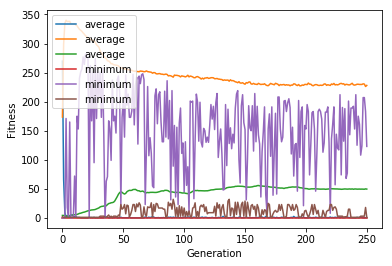

In [10]:
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")
plt.show()

Praeto Front (Baseline)

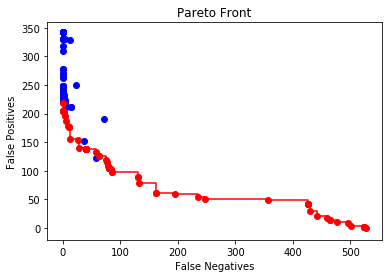

Area Under Curve: 34621.0


In [9]:
"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof]
fitness_2 = [ind.fitness.values[1] for ind in hof]
pop_1 = [ind.fitness.values[0] for ind in pop]
pop_2 = [ind.fitness.values[1] for ind in pop]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("False Negatives")
plt.ylabel("False Positives")
plt.title("Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))

Modified GP (change this)

In [7]:
random.seed(0)

creator.create("FitnessMin2", base.Fitness, weights=(-1.0,-1.0,-1.0))
creator.create("Individual2", gp.PrimitiveTree, fitness=creator.FitnessMin2)

pset = gp.PrimitiveSetTyped("MAIN", in_types=[float, float, float, float, float, float, float], ret_type=bool)
pset.addPrimitive(np.add, in_types=[float, float], ret_type=float)
pset.addPrimitive(np.subtract, in_types=[float, float], ret_type=float)
pset.addPrimitive(np.multiply, in_types=[float, float], ret_type=float)
pset.addPrimitive(np.negative, in_types=[float], ret_type=float)
pset.addPrimitive(np.less, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.greater, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.equal, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.less_equal, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.greater_equal, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.not_equal, in_types=[float, float], ret_type=bool)
pset.addPrimitive(np.logical_not, in_types=[bool], ret_type=bool)
pset.addPrimitive(np.logical_and, in_types=[bool, bool], ret_type=bool)
pset.addPrimitive(np.logical_or, in_types=[bool, bool], ret_type=bool)
pset.addPrimitive(np.logical_xor, in_types=[bool, bool], ret_type=bool)
pset.addEphemeralConstant("float_const3", ephemeral=lambda: random.randint(0, 100), ret_type=float)
pset.addEphemeralConstant("bool_const3", ephemeral=lambda: random.randint(0, 1), ret_type=bool)

pset.renameArguments(ARG0="Pclass")
pset.renameArguments(ARG1="Sex")
pset.renameArguments(ARG2="Age")
pset.renameArguments(ARG3="SibSp")
pset.renameArguments(ARG4="Parch")
pset.renameArguments(ARG5="Fare")
pset.renameArguments(ARG6="Embarked")

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual2, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

def evalClassif(individual, examples, labels, pset):
    func = gp.compile(expr=individual, pset=pset)
    preds = func(*examples.T)

    return (np.sum((preds == 1) & (labels == 0)), np.sum((preds == 0) & (labels == 1)), len(individual))

toolbox.register("evaluate", evalClassif, examples=X, labels=y, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))



NGEN = 250
MU = 500
LAMBDA = 2000
CXPB = 0.2
MUTPB = 0.5

pop = toolbox.population(n=MU)
hof2 = ParetoFrontAUC()
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats,
                          halloffame=hof2)

gen	nevals	avg                      	std                                     	min       	max             
0  	500   	[269.692 173.506   4.266]	[258.51275623 156.01268527   1.67309414]	[0. 0. 2.]	[549. 342.   7.]
1  	1400  	[ 65.806 298.966   4.216]	[159.84779124  95.16216078   2.20665901]	[0. 0. 1.]	[549. 342.  13.]
2  	1411  	[  9.278 334.776   3.856]	[61.77954933 37.95146669  2.44770586]   	[0. 0. 1.]	[549. 342.  15.]
3  	1363  	[  1.766 340.046   3.264]	[20.5325898  12.23093962  2.40047995]   	[  0. 171.   1.]	[402. 342.  17.]
4  	1403  	[  4.036 337.766   3.23 ]	[37.83150412 25.51288388  2.60405453]   	[ 0. 18.  1.]   	[541. 342.  15.]
5  	1408  	[  2.36  338.068   3.61 ]	[32.11414642 20.93177909  3.08186632]   	[0. 2. 1.]      	[546. 342.  17.]
6  	1404  	[  1.074 338.136   4.06 ]	[20.16433793 11.35981972  3.15030157]   	[  0. 165.   1.]	[445. 342.  16.]
7  	1403  	[  5.124 333.656   4.542]	[48.3555232  31.51916344  2.97728668]   	[0. 0. 1.]      	[549. 342.  15.]
8  	1392  	[  4.

67 	1368  	[7.60000e-02 2.51486e+02 4.48560e+01]	[ 0.89343383 10.19675458 13.26224958]   	[  0. 238.  19.]	[ 17. 342. 111.]
68 	1383  	[  1.766 251.744  43.214]            	[24.63305186 18.76044946 10.41327057]   	[ 0. 23.  6.]   	[524. 342. 111.]
69 	1397  	[  0.686 252.902  43.242]            	[ 9.67302455 17.67587045  9.66454531]   	[  0. 118.   3.]	[210. 342.  98.]
70 	1411  	[  0.266 251.66   43.818]            	[ 2.21613267 12.69206051  9.18024379]   	[  0. 226.  19.]	[ 29. 342.  94.]
71 	1392  	[  1.318 251.334  43.416]            	[23.5199676  17.12187034  8.74110657]   	[  0. 107.  18.]	[522. 342.  94.]
72 	1439  	[  0.47  250.978  43.922]            	[ 4.65500806 15.54533744  9.25310305]   	[  0. 138.  18.]	[ 77. 342.  97.]
73 	1383  	[  1.374 250.596  44.   ]            	[21.10161425 16.12714432  8.73498712]   	[  0. 111.  26.]	[437. 342.  94.]
74 	1437  	[  2.096 248.968  44.028]            	[29.23345317 17.87106533  8.91511167]   	[ 0. 55.  1.]   	[459. 342.  96.]
75 	1389

134	1384  	[  0.266 236.882  50.486]            	[ 2.15945456 17.01329116  5.73182379]   	[  0. 195.   1.]	[ 30. 342.  71.]
135	1420  	[  0.86  236.922  51.89 ]            	[10.0481043  21.8002733   5.43671776]   	[ 0. 90.  1.]   	[206. 342.  77.]
136	1366  	[  0.308 237.124  52.34 ]            	[ 4.09452513 18.31208956  4.78376421]   	[  0. 187.  29.]	[ 89. 342.  77.]
137	1389  	[  0.37  235.21   52.742]            	[ 3.24300786 16.02691174  4.62119422]   	[  0. 128.  32.]	[ 56. 341.  84.]
138	1406  	[  0.664 237.63   52.708]            	[ 7.39885829 22.98436643  6.1062866 ]   	[  0. 155.   4.]	[147. 342.  84.]
139	1409  	[  0.456 235.98   53.124]            	[ 4.94328474 18.21931942  5.14087775]   	[  0. 119.  17.]	[ 72. 342.  83.]
140	1409  	[  1.116 236.268  53.362]            	[20.08956306 19.89603418  5.60347713]   	[  0. 144.  16.]	[447. 342.  87.]
141	1431  	[  1.328 235.41   53.552]            	[20.67946847 19.02298347  5.6266594 ]   	[  0. 129.   1.]	[447. 342.  80.]
142	1332

201	1402  	[1.94000e-01 2.29284e+02 5.03380e+01]	[ 1.87945843 22.13909086  4.65228503]   	[  0. 195.   6.]	[ 36. 342.  83.]
202	1437  	[  0.376 231.976  49.624]            	[ 4.17691561 27.28258463  7.21267107]   	[  0. 183.   1.]	[ 89. 342.  83.]
203	1400  	[  1.072 230.078  49.476]            	[15.34349426 25.42006916  5.35625093]   	[ 0. 74.  6.]   	[334. 342.  75.]
204	1389  	[  0.524 230.122  49.904]            	[ 4.69099392 23.91290689  4.84714184]   	[  0. 125.  13.]	[ 78. 342.  81.]
205	1406  	[1.56000e-01 2.28138e+02 5.00800e+01]	[ 1.39271821 18.23093404  4.27008197]   	[  0. 181.  23.]	[ 22. 342.  83.]
206	1430  	[  0.678 227.302  49.986]            	[ 6.05031536 17.58825733  4.3632332 ]   	[  0. 183.   6.]	[ 89. 342.  83.]
207	1411  	[  0.3   228.666  50.168]            	[ 3.26710881 20.78043416  3.50482182]   	[  0. 153.  23.]	[ 61. 342.  77.]
208	1431  	[  1.326 229.342  50.038]            	[21.62932556 25.053723    4.48157963]   	[ 0. 46. 15.]   	[471. 342.  77.]
209	1412

Plots (Modified)

Best individual is: logical_xor(greater_equal(subtract(multiply(Sex, Fare), multiply(Embarked, multiply(multiply(69, negative(negative(subtract(Parch, Sex)))), Parch))), add(subtract(32, multiply(Parch, add(Sex, Pclass))), subtract(multiply(subtract(Embarked, SibSp), negative(add(7, Sex))), add(subtract(2, subtract(subtract(Embarked, Embarked), negative(SibSp))), Embarked)))), greater_equal(subtract(add(Pclass, Age), SibSp), multiply(add(Sex, Age), Age)))
with fitness: (0.0, 223.0)


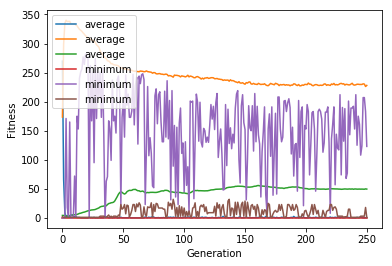

In [8]:
print("Best individual is: %s\nwith fitness: %s" % (hof2[0], hof2[0].fitness))
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")
plt.show()

Praeto Front (Modified)

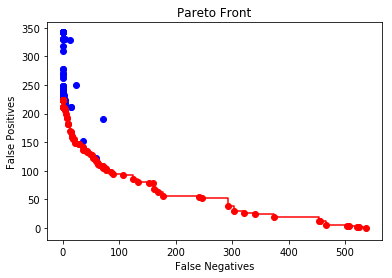

Area Under Curve: 30143.0


In [11]:
"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof2]
fitness_2 = [ind.fitness.values[1] for ind in hof2]
pop_1 = [ind.fitness.values[0] for ind in pop]
pop_2 = [ind.fitness.values[1] for ind in pop]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("False Negatives")
plt.ylabel("False Positives")
plt.title("Pareto Front")
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))

AUC Graph

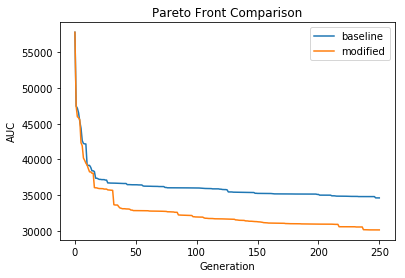

In [12]:
gen = logbook.select("gen")
plt.plot(gen, hof.aucs, label="baseline")
plt.plot(gen, hof2.aucs, label="modified")
plt.xlabel("Generation")
plt.ylabel("AUC")
plt.legend(loc="upper right")
plt.title("Pareto Front Comparison")
plt.show()

In [14]:
test_data = np.genfromtxt(open("../data/test.csv"), delimiter=',', skip_header=1, usecols=(0, 1, 4, 5, 6, 7, 9, 11), converters={4: sex, 11: embarked})
test_ids = test_data[:, 0]
test_X = test_data[:, 1:]
fill_missing(test_X)

func = gp.compile(expr=hof2[0], pset=pset)
preds = func(*test_X.T)
output = np.stack((test_ids, preds), axis=1)
np.savetxt("gp_submission.csv", output, fmt="%i", delimiter=',', header="PassengerId,Survived", comments='')